In [1]:
%matplotlib inline
import glob
import h5py
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import skopi as sk

import time
import numpy as np
from tqdm import tqdm

from IPython.display import clear_output
from sklearn.decomposition import PCA, IncrementalPCA

import os
import sys
sys.path.append('../src/')
from embedding import batch_PCA, run_PCA

# Direct PCA

In [2]:
dataset_dir='/sdf/scratch/fpoitevi/anass_internship/datasets/cryoem/sim/'

defocus = [f'{0.5*i}' for i in range(1,7)]
copy_1 = list(range(5))
copy_2 = list(range(5, 10))

files_1 = []
files_2 = []

for copy in copy_1 :
    files_1 += [i for i in os.listdir(dataset_dir) if i.startswith(f'4v6x_randomrot_copy{copy}')]

for copy in copy_2 :
    files_2 += [i for i in os.listdir(dataset_dir) if i.startswith(f'4v6x_randomrot_copy{copy}')]

batch_size = 48
dim = 648

In [3]:
data_1 = []
data_2 = []

defoc_1 = []
defoc_2 = []

angle_1 = []
angle_2 = []

for f in files_1 :
    batch = h5py.File(os.path.join(dataset_dir, f), 'r')
    if 'coordinates' in batch.keys() :
        data_1.append(batch['data'][:])
        defoc_1.append(f.split('defocus')[1].split('_no_noise')[0])
        angle_1.append(batch['coordinates'][:, 3])

for f in files_2 :
    batch = h5py.File(os.path.join(dataset_dir, f), 'r')
    if 'coordinates' in batch.keys() :
        data_2.append(batch['data'][:])
        defoc_2.append(f.split('defocus')[1].split('_no_noise')[0])
        angle_2.append(batch['coordinates'][:, 3])

    
size_1 = len(data_1)
size_2 = len(data_2)
    
data_1 = np.array(data_1)
data_2 = np.array(data_2)

defoc_1 = np.array(defoc_1)
defoc_2 = np.array(defoc_2)

angle_1 = np.array(angle_1)
angle_2 = np.array(angle_2)

In [4]:
print(f"Memory cost : {(data_1.nbytes + data_2.nbytes)/1024**3} gb")

Memory cost : 2.7030487060546875 gb


In [5]:
n_comp = 48

In [6]:
t1 = time.time()

pca_1 = PCA(n_components=n_comp)
pca_1.fit(data_1.reshape(size_1 * batch_size, dim**2))

t2 = time.time()
print(f'PCA 1 fitted in {t2 - t1}s')

PCA 1 fitted in 17.210554838180542s


In [7]:
t1 = time.time()

pca_2 = PCA(n_components=n_comp)
pca_2.fit(data_2.reshape(size_2 * batch_size, dim**2))

t2 = time.time()
print(f'PCA 2 fitted in {t2 - t1}s')

PCA 2 fitted in 15.687224864959717s


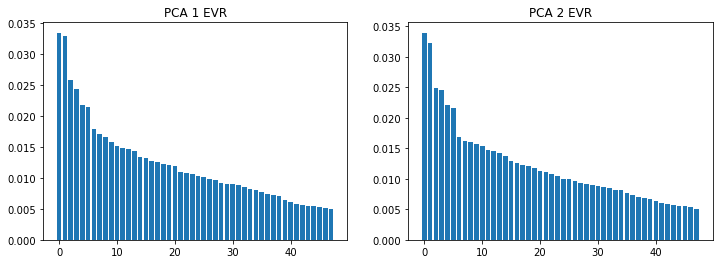

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.bar(np.arange(n_comp), pca_1.explained_variance_ratio_)
ax1.set_title('PCA 1 EVR')
ax2.bar(np.arange(n_comp), pca_2.explained_variance_ratio_)
ax2.set_title('PCA 2 EVR')
plt.show()

In [9]:
fig.savefig('../images/pca_evr.png')

In [10]:
resized_11 = pca_1.transform(data_1.reshape(size_1 * batch_size, dim**2))
resized_12 = pca_1.transform(data_2.reshape(size_2 * batch_size, dim**2))

resized_21 = pca_2.transform(data_1.reshape(size_1 * batch_size, dim**2))
resized_22 = pca_2.transform(data_2.reshape(size_2 * batch_size, dim**2))

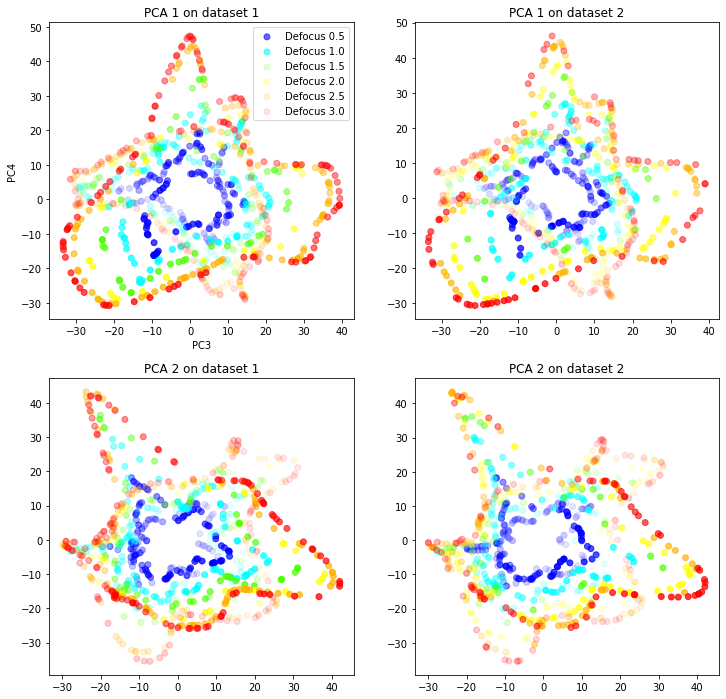

In [44]:
def angle_color(angle, color) :
    r, g, b = color
    alpha = 0.1 + (1 - np.abs(angle / 180))**2 * 0.7
    return r, g, b, alpha

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

pc_x, pc_y = 2, 3
base_colors = [(0., 0., 1.), (0., 1., 1.), (0.3, 1., 0.), (1., 1., 0), (1., 0.7, 0.), (1., 0., 0.)]

for i in range(len(defocus)) :
    d = defocus[i]
    
    index_1 = np.array([np.full(batch_size, (defoc_1 == d)[j]) for j in range(len(defoc_1))]).flatten()
    index_2 = np.array([np.full(batch_size, (defoc_2 == d)[j]) for j in range(len(defoc_2))]).flatten()
    
    col_1 = [angle_color(angle, base_colors[i]) for angle in angle_1.flatten()[index_1]]
    col_2 = [angle_color(angle, base_colors[i]) for angle in angle_2.flatten()[index_2]]
    
    ax1.scatter(resized_11[index_1, pc_x], resized_11[index_1, pc_y], c=col_1, label=f'Defocus {d}')
    ax2.scatter(resized_12[index_2, pc_x], resized_12[index_2, pc_y], c=col_2)
    ax3.scatter(resized_21[index_1, pc_x], resized_21[index_1, pc_y], c=col_1)
    ax4.scatter(resized_22[index_2, pc_x], resized_22[index_2, pc_y], c=col_2)
    

ax1.set_title('PCA 1 on dataset 1')
ax2.set_title('PCA 1 on dataset 2')
ax3.set_title('PCA 2 on dataset 1')
ax4.set_title('PCA 2 on dataset 2')

ax1.legend(loc='upper right')
ax1.set_xlabel(f'PC{pc_x + 1}')
ax1.set_ylabel(f'PC{pc_x + 2}')

plt.show()

In [71]:
fig.savefig('../images/defoc_pca.png')

In [28]:
eigenimages_1 = np.dot(resized_11.T, data_1.reshape(size_1 * batch_size, dim**2)).reshape(n_comp, dim, dim)
eigenimages_2 = np.dot(resized_22.T, data_2.reshape(size_2 * batch_size, dim**2)).reshape(n_comp, dim, dim)

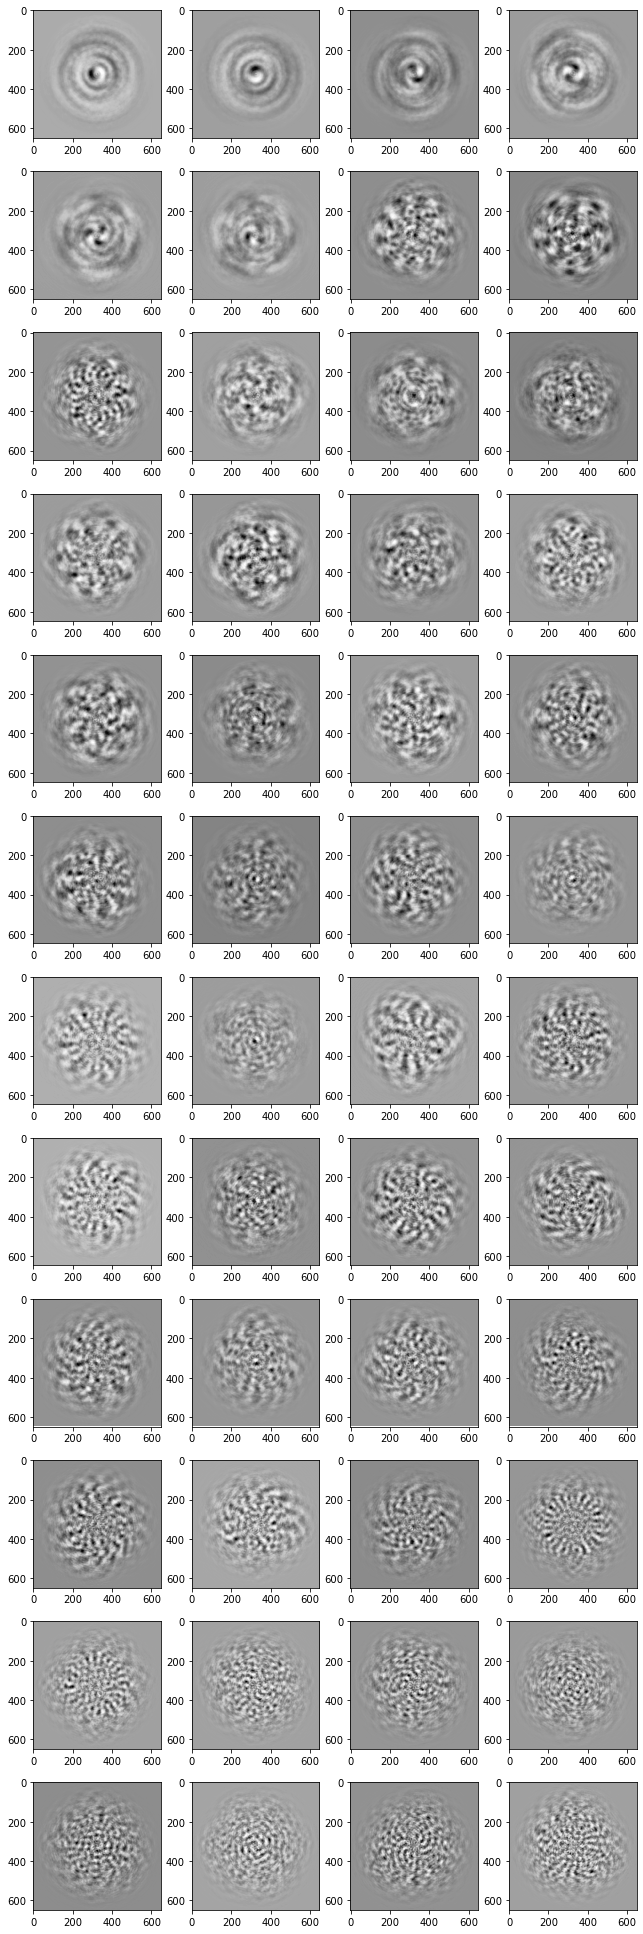

In [32]:
nrows=12
ncols=4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9, 9*(nrows//ncols)))
for i in range(nrows):
    for j in range(ncols):
        image = eigenimages_1[i*ncols+j]
        axs[i,j].imshow(image, interpolation='none', cmap='Greys_r')
plt.tight_layout()

In [41]:
resized_11[0].dot(eigenimages_1) np.dot()

ValueError: shapes (48,) and (48,648,648) not aligned: 48 (dim 0) != 648 (dim 1)

# Incremental PCA

In [15]:
files = files_1 + files_2
size = size_1 + size_2

data = np.concatenate((data_1, data_2))
defoc = np.concatenate((defoc_1, defoc_2))
angle = np.concatenate((angle_1, angle_2))

In [16]:
n_comp = 48

In [17]:
t1 = time.time()

pca = IncrementalPCA(n_components=n_comp, batch_size=batch_size)

for batch in tqdm(data) :
    pca.partial_fit(batch.reshape(batch_size, dim**2))

t2 = time.time()
print(f'iPCA fitted in {t2 - t1}s')

/opt/anaconda/envs/ana/lib/python3.7/site-packages/sklearn/decomposition/_incremental_pca.py:316: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/opt/anaconda/envs/ana/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


iPCA fitted in 1092.8430449962616s


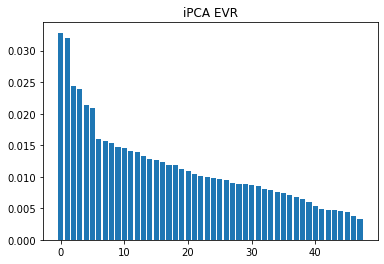

In [18]:
fig = plt.figure(figsize=(6, 4))
plt.bar(np.arange(n_comp), pca.explained_variance_ratio_)
plt.title('iPCA EVR')
plt.show()

In [19]:
fig.savefig('../images/ipca_evr.png')

In [20]:
resized = pca.transform(data.reshape(size * batch_size, dim**2))

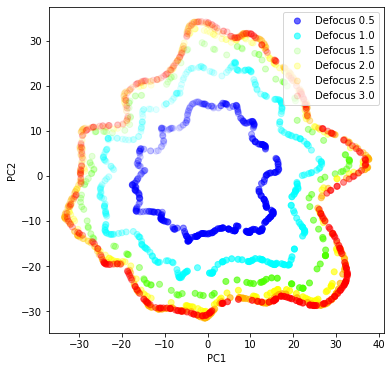

In [21]:
fig = plt.figure(figsize=(6, 6))

base_colors = [(0., 0., 1.), (0., 1., 1.), (0.3, 1., 0.), (1., 1., 0), (1., 0.7, 0.), (1., 0., 0.)]

for i in range(len(defocus)) :
    d = defocus[i]
    index = np.array([np.full(batch_size, (defoc == d)[j]) for j in range(len(defoc))]).flatten()
    col = [angle_color(angle, base_colors[i]) for angle in angle.flatten()[index]]
    plt.scatter(resized[index, 0], resized[index, 1], c=col, label=f'Defocus {d}')

plt.legend(loc='upper right')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.show()

In [22]:
fig.savefig('../images/defoc_ipca.png')

# Subsampling

In [44]:
sub_index = 4*np.arange(dim//4)
sub_dim = len(sub_index)
sub_data = data[:, :, sub_index][:, :, :, sub_index]

In [45]:
n_comp = 48

In [46]:
t1 = time.time()

pca = IncrementalPCA(n_components=n_comp, batch_size=batch_size)

for batch in sub_data :
    pca.partial_fit(batch.reshape(batch_size, sub_dim**2))

t2 = time.time()
print(f'Subsampled iPCA fitted in {t2 - t1}s')

/opt/anaconda/envs/ana/lib/python3.7/site-packages/sklearn/decomposition/_incremental_pca.py:316: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/opt/anaconda/envs/ana/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Subsampled iPCA fitted in 20.456767082214355s


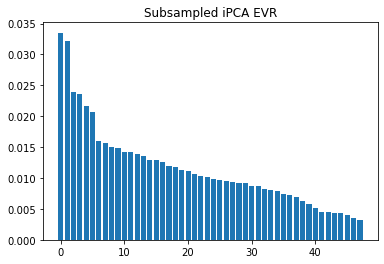

In [47]:
fig = plt.figure(figsize=(6, 4))
plt.bar(np.arange(n_comp), pca.explained_variance_ratio_)
plt.title('Subsampled iPCA EVR')
plt.show()

In [48]:
fig.savefig('../images/ipca_evr_subsampled.png')

In [49]:
sub_resized = pca.transform(sub_data.reshape(size * batch_size, sub_dim**2))

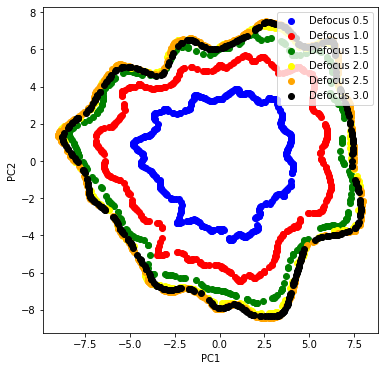

In [50]:
fig = plt.figure(figsize=(6, 6))

colors = ['blue', 'red', 'green', 'yellow', 'orange', 'black']

for i in range(len(defocus)) :
    d = defocus[i]
    index = np.array([np.full(batch_size, (defoc == d)[j]) for j in range(len(defoc))]).flatten()
    col = [angle_color(angle, base_colors[i]) for angle in angle.flatten()[index]]
    plt.scatter(sub_resized[index, 0], sub_resized[index, 1], c=col, label=f'Defocus {d}')

plt.legend(loc='upper right')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.show()

In [51]:
fig.savefig('../images/defoc_ipca_subsampled.png')

In [ ]:
import numpy as np
import pandas as pd
data = np.load('/sdf/grou648p/cryoem/g/ML/vaegan/datasets/sim/randomrot1D_nodisorder_nonoise_128x128/cryo_sim_128x128.npy')
labels = pd.read_csv('/sdf/group/cryoem/g/ML/vaegan/datasets/sim/randomrot1D_nodisorder_nonoise_128x128/cryo_sim_labels_128x128.csv')